In [33]:
import torchvision as tv
import torch
import torchvision.transforms as transforms

num_workers = 0
# how many samples per batch to load
batch_size = 20

transform = transforms.Compose([
    transforms.ToTensor(),
 ])  

trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
testset  = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

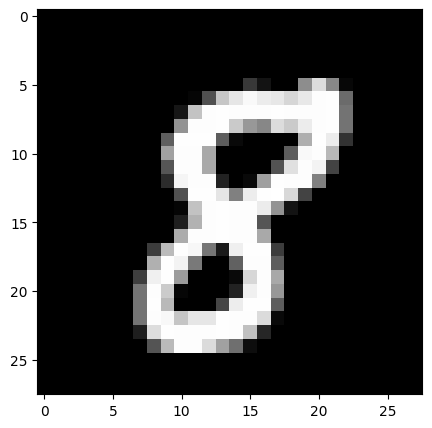

In [22]:
import matplotlib.pyplot as plt
import numpy as np
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [87]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4 * 7 * 7, 12)  # FC layer to latent space

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(12, 4 * 7 * 7)  # FC layer from latent space
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 4, 7, 7)
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        return x

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# initialize the NN
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=196, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=196, bias=True)
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


In [98]:
# specify loss function
criterion = nn.L1Loss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 2.287429
Epoch: 2 	Training Loss: 1.915962
Epoch: 3 	Training Loss: 1.745764
Epoch: 4 	Training Loss: 1.413359
Epoch: 5 	Training Loss: 1.250830
Epoch: 6 	Training Loss: 1.184622
Epoch: 7 	Training Loss: 1.159870
Epoch: 8 	Training Loss: 1.146548
Epoch: 9 	Training Loss: 1.138988
Epoch: 10 	Training Loss: 1.134262
Epoch: 11 	Training Loss: 1.130782
Epoch: 12 	Training Loss: 1.127777
Epoch: 13 	Training Loss: 1.125548
Epoch: 14 	Training Loss: 1.123943
Epoch: 15 	Training Loss: 1.121706
Epoch: 16 	Training Loss: 1.120239
Epoch: 17 	Training Loss: 1.118900
Epoch: 18 	Training Loss: 1.117222
Epoch: 19 	Training Loss: 1.116188
Epoch: 20 	Training Loss: 1.115162


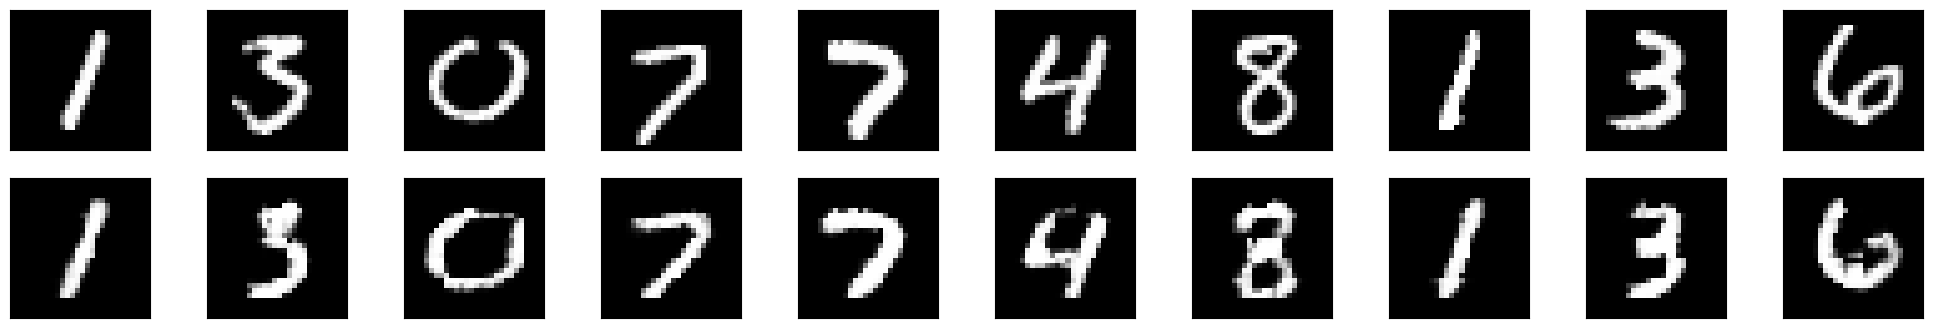

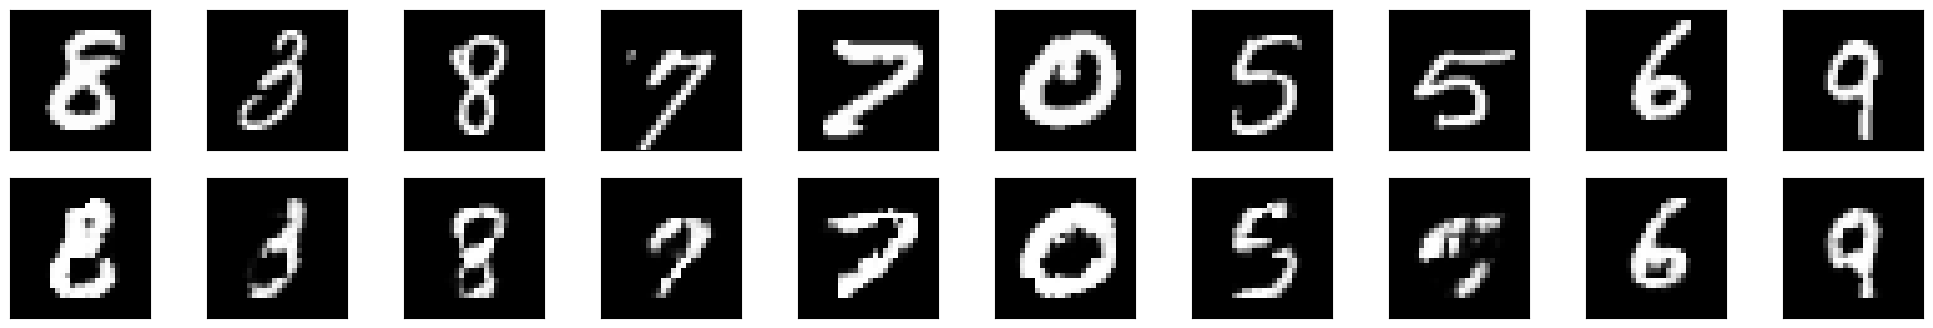

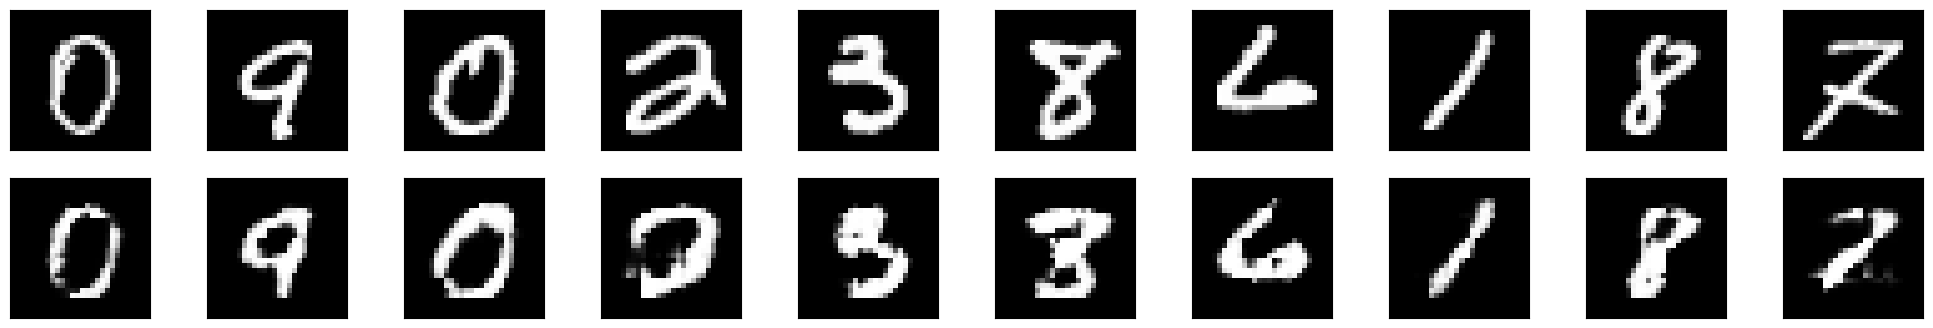

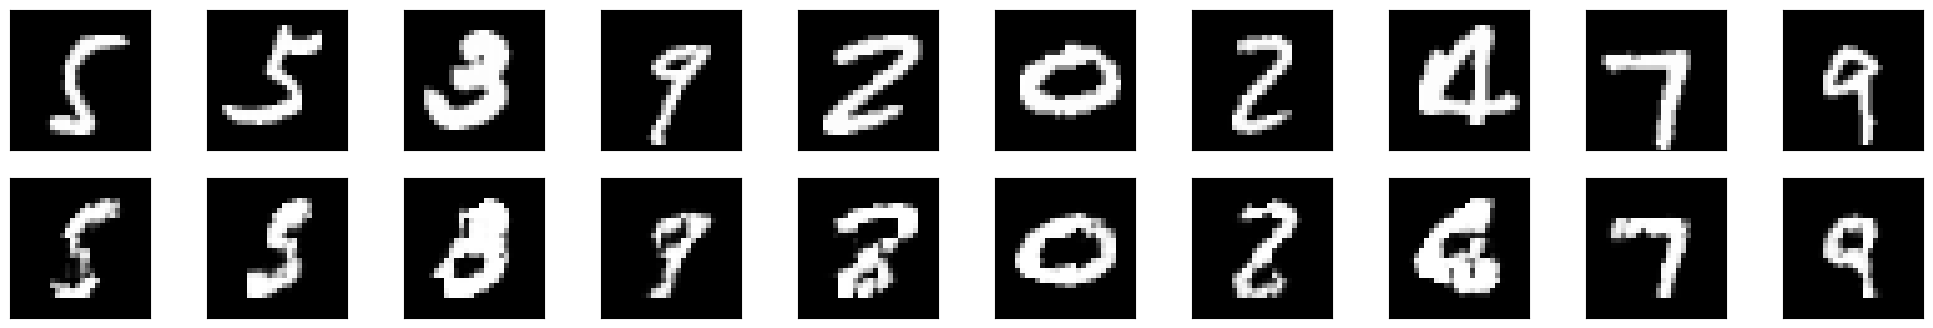

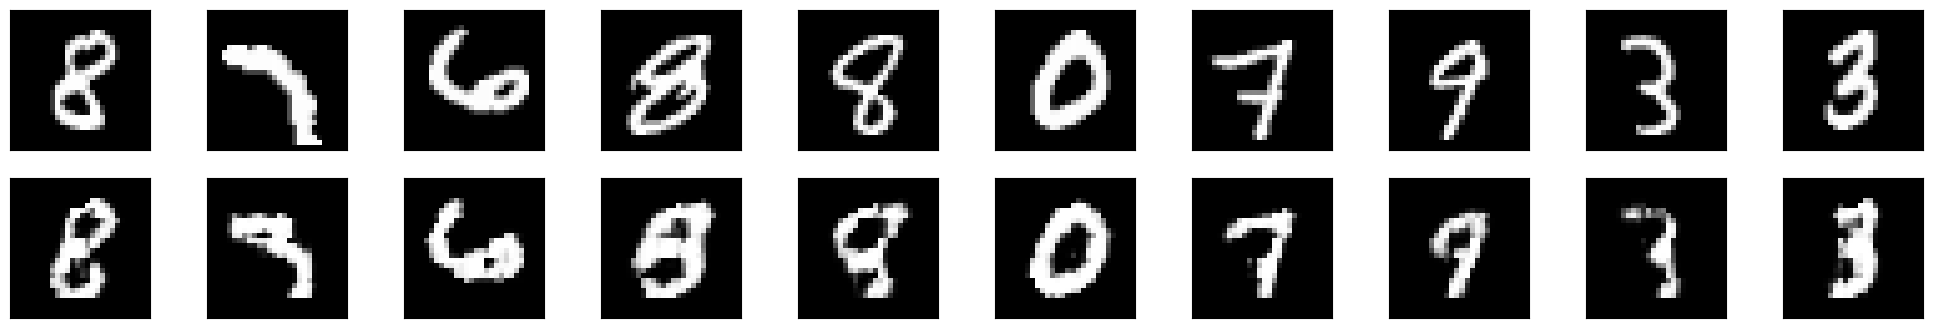

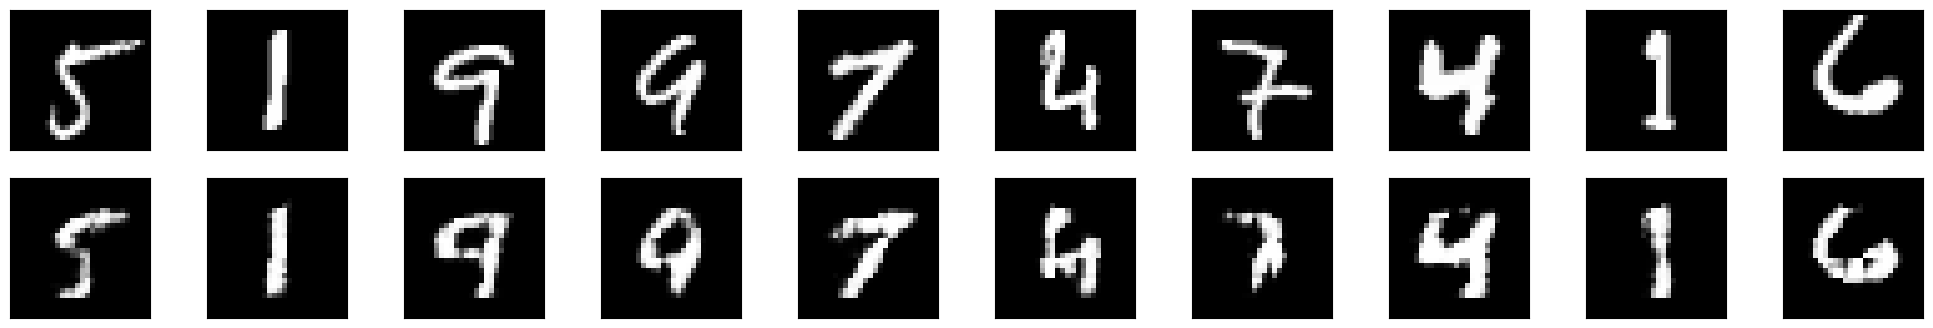

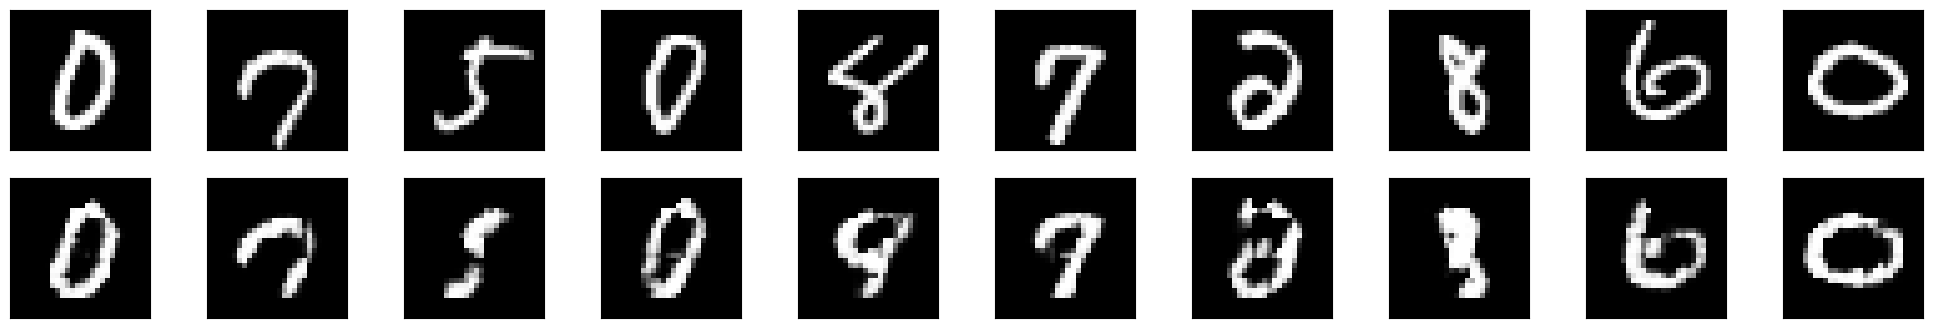

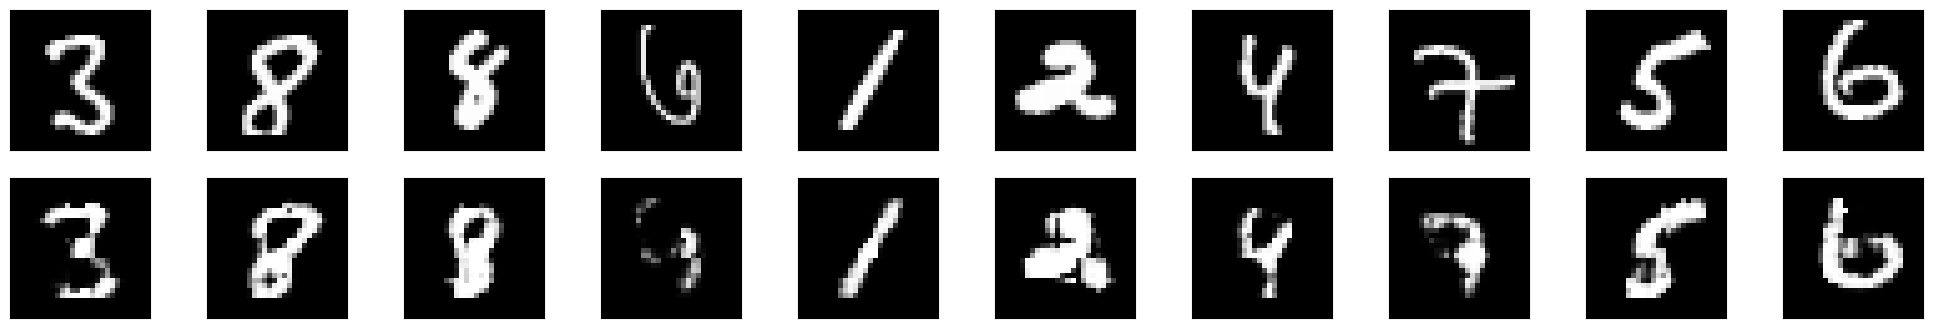

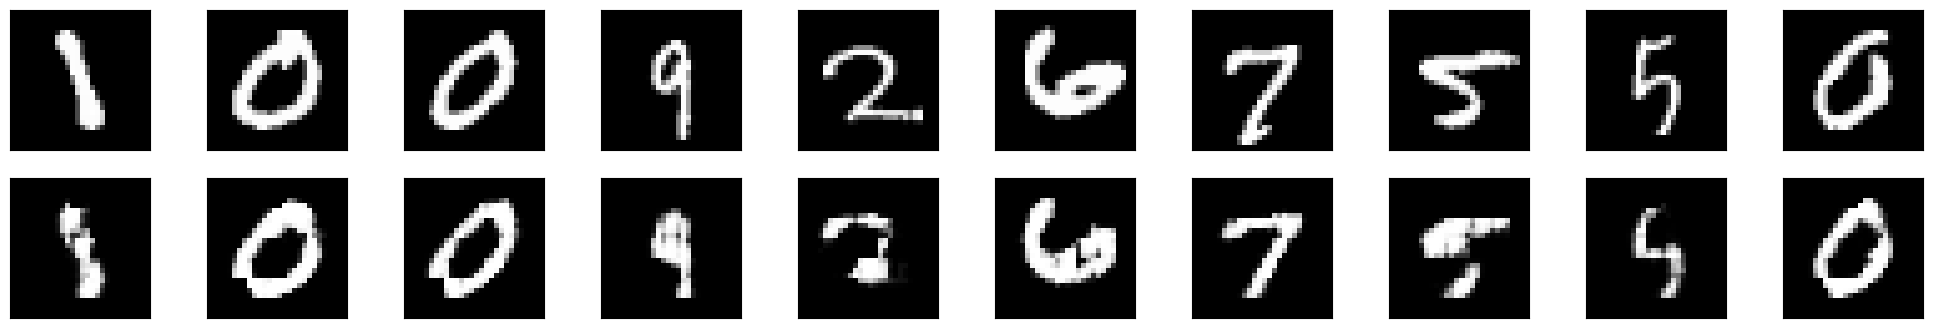

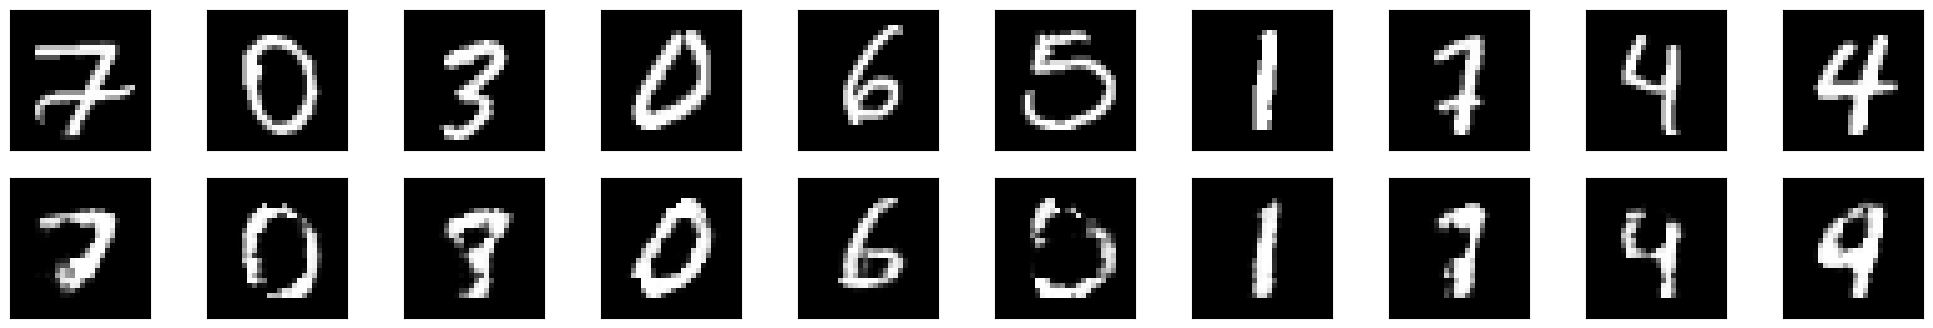

In [100]:
import numpy as np
import matplotlib.pyplot as plt


# obtain one batch of test images
dataiter = iter(test_loader)

for x in range(10):
    images, labels = next(dataiter)

    # get sample outputs
    images = images.to(device)

    output = model(images)
    # prep images for display
    images = images.cpu().numpy()

    # output is resized into a batch of iages
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
